<a href="https://colab.research.google.com/github/bassim1/COP28hack4climate/blob/main/Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install rasterio==1.3.5 --quiet gdal==3.4.3 pystac pystac_client planetary_computer tenacity rich pandas==1.5.3 torch torchvision transformers huggingface_hub

In [ ]:
%pip install -U git+https://github.com/luca-medeiros/lang-segment-anything.git

In [22]:
from PIL import Image
from lang_sam import LangSAM

In [23]:
image_name = "sample.jpg"
image_pil = Image.open(image_name)

In [24]:
model = LangSAM()

final text_encoder_type: bert-base-uncased
Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


In [25]:
text_prompt = "water"

In [26]:
masks, boxes, phrases, logits = model.predict(image_pil, text_prompt)

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


In [27]:
import numpy as np
from lang_sam.utils import draw_image

In [28]:
as_array = np.array(image_pil)
image = draw_image(as_array, masks, boxes, phrases)

In [29]:
masks.shape

torch.Size([1, 810, 1440])

In [30]:
boxes.shape

torch.Size([1, 4])

In [31]:
phrases

['water']

In [32]:
logits

tensor([0.7664])

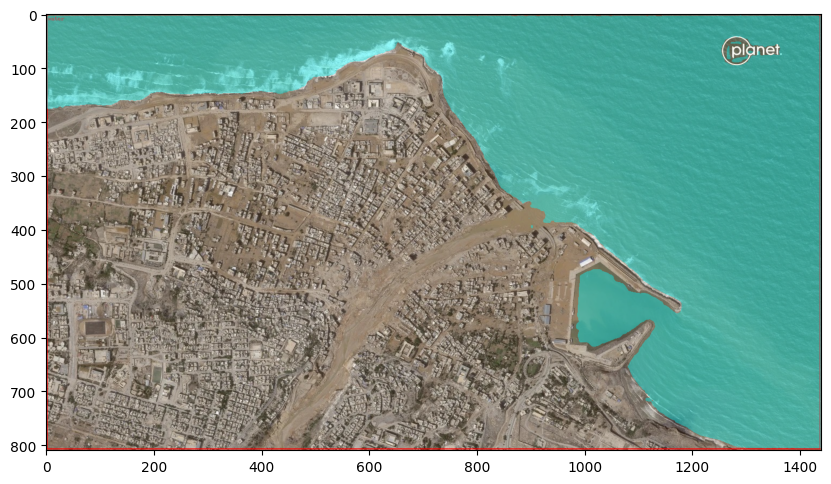

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.imshow(image)

In [34]:
from lang_sam.utils import get_contours, contour_to_points
import numpy as np
from shapely.geometry import Polygon
from shapely import affinity, wkt
import geopandas as gpd
import os

In [35]:
polys = []
for mask in masks:
    contours = get_contours(np.array(mask))
    for contour in contours:
        points = contour_to_points(contour)
        polygon = Polygon(points).simplify(2) # 2px simplification
        polygon = affinity.scale(polygon, yfact=-1)

        polys.append(polygon)

# change crs
gdf = gpd.GeoDataFrame(index = phrases, crs = 'epsg:27700', geometry = polys)
file_name = f'{os.path.basename(image_name)}.gpkg'
output_filepath = os.path.join(file_name)
gdf.to_file(output_filepath, layer=text_prompt, driver='GPKG')

In [36]:
print(os.getcwd())

/content


In [ ]:
# difference_gdf = gpd.overlay(gdf1, gdf2, how='difference')